# Summary

This submission is to achieve level 2 in "unstructured" and "workflow". I employed a multinomial Naive Bayes classifier in order to create a model to classify an article as "fake" or "real" based on its words and phrases.The data set contained a large number of articles (takes a long time to train), therefore, I downsampled this to 1,000 articles in order to speed up my training and evaluation (using shuffle).
Then I persued answering two questions:

1. How accurately can you predict real vs fake news from the text?
2. Are titles of real or fake news more similar to one another based on euclidean distance? 


## Descroption of dataset
This dataset is about fake and real news. Since 2016 word "fake news" has been used more than ever based on the [Ngram](https://books.google.com/ngrams/graph?content=fake+news&year_start=1980&year_end=2019&corpus=26&smoothing=0#). We may probably easily guess what could be the reason for that, as it has been a hot topic during the US presidency at the time, from begining 2016 (start of election debates)to early 2021(end of presidency). 
![Fakenews Application by the Time](fakenews_application_history.png)

## Libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt

## Reading a text-based dataset into pandas

In [2]:
# reading csv file into pandas from a URL address
df_articles = pd.read_csv("https://raw.githubusercontent.com/lutzhamel/fake-news/master/data/fake_or_real_news.csv", encoding='latin-1')

In [3]:
#Take a look at the dataset
df_articles.head()

,id,title,text,label
0,8476,You Can Smell Hillaryâs Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"â Kaydee King (@KaydeeKing) November 9, 2016...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [5]:
#shape of dataframe
df_articles.shape

(6335, 4)

In [6]:
# selecting 1000 samples out of 6,335 samples, randomly.
df_articles1 = df_articles.sample(n=1000, random_state=1,)
df_articles1.shape

(1000, 4)

## Exploratory Data Analysis (EDA)

In [6]:
#Check for NaN under an entire DataFrame
df_articles1.isnull().values.any()

False

In [7]:
#summary of a DataFrame
df_articles1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 3553 to 694
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      1000 non-null   int64 
 1   title   1000 non-null   object
 2   text    1000 non-null   object
 3   label   1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 39.1+ KB


In [8]:
#gartting number of fake and real text out of total 1,000 samples
df_articles1[['text', 'label']].groupby('label').count()

,text
label,
FAKE,503
REAL,497


We have 503 FAKE articles and 497 REAL articles. As we can see above, number of samples are close for two classes. Therefore it could be considered as a balanced dataset.

In [7]:
# convert label to a numerical variable
df_articles1['label_num'] = df_articles1.label.map({'REAL':0, 'FAKE':1})
df_articles1.head()

,id,title,text,label,label_num
3553,4002,Pentagon weighs using force to protect US-back...,Senior U.S. military leaders and defense offic...,REAL,0
5826,7941,UK announces new troop deployment near Russia'...,Military British Defense Secretary Michael Fal...,FAKE,1
6140,10312,Dog Waited Faithfully For Over A Month After H...,There have been horror stories of families lea...,FAKE,1
2487,362,Defense Secretary Carter endorses 3-year timel...,Defense Secretary Ash Carter on Wednesday endo...,REAL,0
1720,7878,Hilarious Cartoon Reveals 2016 Political Versi...,Pinterest \nC.E. Dyer writes that the disaster...,FAKE,1


In [8]:
#adding a new column to the dataframe containing length of each article
df_articles1['text_len'] = df_articles1.text.apply(len)
df_articles1.head()

,id,title,text,label,label_num,text_len
3553,4002,Pentagon weighs using force to protect US-back...,Senior U.S. military leaders and defense offic...,REAL,0,5192
5826,7941,UK announces new troop deployment near Russia'...,Military British Defense Secretary Michael Fal...,FAKE,1,2338
6140,10312,Dog Waited Faithfully For Over A Month After H...,There have been horror stories of families lea...,FAKE,1,196
2487,362,Defense Secretary Carter endorses 3-year timel...,Defense Secretary Ash Carter on Wednesday endo...,REAL,0,3675
1720,7878,Hilarious Cartoon Reveals 2016 Political Versi...,Pinterest \nC.E. Dyer writes that the disaster...,FAKE,1,3041


Text(0.5, 0, 'text Length')

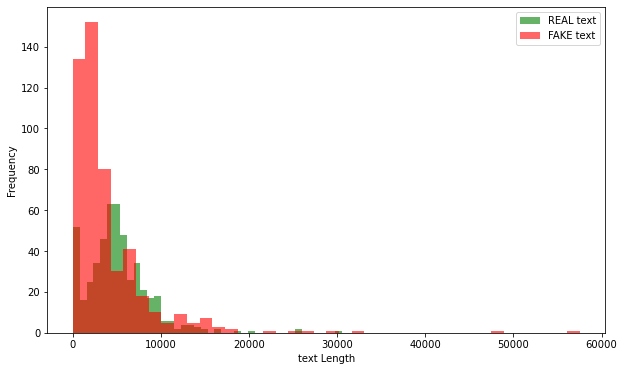

In [9]:
#Distribution of articles length based on fake/real fact
plt.figure(figsize=(10, 6))

df_articles1[df_articles1.label=='REAL'].text_len.plot(bins=40, kind='hist', color='green', 
                                       label='REAL text', alpha=0.6)
df_articles1[df_articles1.label=='FAKE'].text_len.plot(bins=40,kind='hist', color='red', 
                                       label='FAKE text', alpha=0.6)
plt.legend()
plt.xlabel("text Length")

From the above plot we can understand fake articles are mostly shorter articles, however, it happens when they are super long as we can see from the histogram skewness to the right side. On the other hand real articles distribution is more similar to a normal distributon. 

##  Text Pre-processing

In [12]:
#The following function will remove all stopwords (defined in the list of english stopwords in nltk) and punctuations from the text 
import string

from nltk.corpus import stopwords

def text_process(text):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    STOPWORDS = stopwords.words('english')
    # making a list of characters of the text, excluding punctuations (!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~)
    nopunc = [char for char in text if char not in string.punctuation]

    # Join the characters with no space in between to form the text (excluding punctuations) again.
    nopunc = ''.join(nopunc)
    
    # splitting string nopunc with spaces and making all words lowercase then
    #check if the word exsists in STOPWORDS collection, if not join those words with space in between.
    return ' '.join([word for word in nopunc.split() if word.lower() not in STOPWORDS])

In [13]:
#making a new column in the dataframe applying the text-preprocessing function to the "text" column.
df_articles1['clean_txt'] = df_articles1.text.apply(text_process)
df_articles1.head()

,id,title,text,label,label_num,text_len,clean_txt
3553,4002,Pentagon weighs using force to protect US-back...,Senior U.S. military leaders and defense offic...,REAL,0,5192,Senior US military leaders defense officials d...
5826,7941,UK announces new troop deployment near Russia'...,Military British Defense Secretary Michael Fal...,FAKE,1,2338,Military British Defense Secretary Michael Fal...
6140,10312,Dog Waited Faithfully For Over A Month After H...,There have been horror stories of families lea...,FAKE,1,196,horror stories families leaving behind pets mo...
2487,362,Defense Secretary Carter endorses 3-year timel...,Defense Secretary Ash Carter on Wednesday endo...,REAL,0,3675,Defense Secretary Ash Carter Wednesday endorse...
1720,7878,Hilarious Cartoon Reveals 2016 Political Versi...,Pinterest \nC.E. Dyer writes that the disaster...,FAKE,1,3041,Pinterest CE Dyer writes disaster Obamacare ge...


## Vectorization

In [14]:
# defining X (input) and y (label) from the dataframe columns for later use in COUNTVECTORIZER
X = df_articles1.clean_txt.values
y = df_articles1.label_num.values

#shape and dimension of X and y arrays
print(X.shape)
print(y.shape)
print(X.ndim)
print(y.ndim)

(1000,)
(1000,)
1
1


In [15]:
# X and y are numpy.ndarray
print(type(X))
print(type(y))
# print(X[:5])

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [16]:
## splitting dataset to train (80%/800 samples) and test (20%/200 samples) sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size = 0.2 )
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(800,)
(200,)
(800,)
(200,)


Now we need to convert text documents to a matrix of token counts

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
# instantiate the vectorizer object (content vectorizer) and training (fitting) that on the train dataset
vect = CountVectorizer()
vect.fit(X_train)

CountVectorizer()

In [18]:
# learn training data vocabulary, then use it to create a document-term matrix
X_train_dtm = vect.transform(X_train)
# examine the document-term matrix
X_train_dtm

<800x33679 sparse matrix of type '<class 'numpy.int64'>'
	with 228793 stored elements in Compressed Sparse Row format>

This train dtm matrix contains 800 train articles samples (rows) and 33,679  vocabs (columns). Its data type is integer, meaning all 0,1,2 (if two of a specific vocab in a text)..

In [56]:
# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test)
X_test_dtm

<200x33679 sparse matrix of type '<class 'numpy.int64'>'
	with 54202 stored elements in Compressed Sparse Row format>

This test dtm matrix contains 200 test articles samples (rows) and 33,679 fitted vocabulary (columns). 

In [58]:
# import and instantiate a Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

In [59]:
# Fit Naive Bayes classifier according to X, y
nb.fit(X_train_dtm, y_train)

MultinomialNB()

In [60]:
# make class predictions for X_test_dtm
y_pred_class = nb.predict(X_test_dtm)

In [61]:
# calculate accuracy of class predictions
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred_class)

0.865

In [62]:
# print the confusion matrix
metrics.confusion_matrix(y_test, y_pred_class)

array([[92,  8],
       [19, 81]])

In [174]:
# calculate predicted probabilities for X_test_dtm (poorly calibrated)
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]
y_pred_prob

array([1.00000000e+000, 5.19949751e-105, 9.97274847e-001, 4.63755648e-067,
       9.99785224e-001, 5.14990347e-008, 9.99942938e-001, 9.99995756e-001,
       1.00000000e+000, 9.99999750e-001, 2.61152235e-003, 7.95109953e-099,
       9.99998599e-001, 3.27137554e-023, 4.52262573e-035, 1.00000000e+000,
       8.03541384e-016, 1.22201549e-082, 5.29693906e-002, 7.91850072e-001,
       9.63666291e-083, 5.32151510e-053, 2.12022456e-270, 7.28822708e-040,
       1.00000000e+000, 5.54962516e-019, 9.99999898e-001, 5.52591534e-023,
       1.00000000e+000, 1.00000000e+000, 4.88958161e-118, 1.00000000e+000,
       7.62683497e-042, 1.00000000e+000, 6.66879081e-116, 1.00000000e+000,
       1.00000000e+000, 1.00000000e+000, 9.99999468e-001, 7.23180459e-001,
       1.66660758e-126, 1.00000000e+000, 1.00000000e+000, 1.43846219e-050,
       1.00000000e+000, 1.83541207e-075, 1.00000000e+000, 6.86099835e-057,
       7.68817277e-050, 2.10238704e-013, 1.00000000e+000, 1.00000000e+000,
       1.13372992e-064, 1

In [175]:
# calculate AUC
metrics.roc_auc_score(y_test, y_pred_prob)

0.9439964157706093

##  Tuning the vectorizer

In [176]:
# remove English stop words
vect = CountVectorizer(stop_words='english')

### Similarity of titles (fake and real) using euclidean distance

In [217]:
counts_real = CountVectorizer()

In [218]:
counts_fake = CountVectorizer()

In [214]:
df_articles_fake = df_articles[df_articles.label=='FAKE']
df_articles_fake.head()

,id,title,text,label
0,8476,You Can Smell Hillaryâs Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
3,10142,Bernie supporters on Twitter erupt in anger ag...,"â Kaydee King (@KaydeeKing) November 9, 2016...",FAKE
5,6903,"Tehran, USA","\nIâm not an immigrant, but my grandparent...",FAKE
6,7341,Girl Horrified At What She Watches Boyfriend D...,"Share This Baylee Luciani (left), Screenshot o...",FAKE


In [215]:
df_articles_real = df_articles[df_articles.label=='REAL']
df_articles_real.head()

,id,title,text,label
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
7,95,âBritainâs Schindlerâ Dies at 106,A Czech stockbroker who saved more than 650 Je...,REAL
8,4869,Fact check: Trump and Clinton at the 'commande...,Hillary Clinton and Donald Trump made some ina...,REAL
9,2909,Iran reportedly makes new push for uranium con...,Iranian negotiators reportedly have made a las...,REAL


Learning the dictionary of real articles

In [219]:
counts_real.fit_transform(df_articles_real.title.values)

<3171x5807 sparse matrix of type '<class 'numpy.int64'>'
	with 30376 stored elements in Compressed Sparse Row format>

Learning the dictionary of fake articles

In [220]:
counts_fake.fit_transform(df_articles_fake.title.values)

<3164x8051 sparse matrix of type '<class 'numpy.int64'>'
	with 33599 stored elements in Compressed Sparse Row format>

In [221]:
counts_real.vocabulary_

{'kerry': 2832,
 'to': 5256,
 'go': 2238,
 'paris': 3683,
 'in': 2589,
 'gesture': 2211,
 'of': 3523,
 'sympathy': 5093,
 'the': 5187,
 'battle': 531,
 'new': 3440,
 'york': 5791,
 'why': 5694,
 'this': 5213,
 'primary': 3948,
 'matters': 3166,
 'britainâ': 738,
 'schindlerâ': 4498,
 'dies': 1477,
 'at': 422,
 '106': 5,
 'fact': 1899,
 'check': 932,
 'trump': 5348,
 'and': 295,
 'clinton': 1006,
 'commander': 1054,
 'chief': 944,
 'forum': 2098,
 'iran': 2705,
 'reportedly': 4263,
 'makes': 3105,
 'push': 4049,
 'for': 2077,
 'uranium': 5489,
 'concessions': 1092,
 'nuclear': 3489,
 'talks': 5115,
 'with': 5723,
 'all': 253,
 'three': 5223,
 'clintons': 1008,
 'iowa': 2701,
 'glimpse': 2232,
 'fire': 2012,
 'that': 5185,
 'has': 2363,
 'eluded': 1720,
 'hillary': 2442,
 'clintonâ': 1010,
 'campaign': 816,
 'donald': 1585,
 'trumpâ': 5352,
 'shockingly': 4635,
 'weak': 5649,
 'delegate': 1384,
 'game': 2178,
 'somehow': 4788,
 'got': 2258,
 'even': 1817,
 'worse': 5756,
 'takes': 5109,


In [222]:
counts_fake.vocabulary_

{'you': 8008,
 'can': 1152,
 'smell': 6622,
 'hillaryâ': 3400,
 'fear': 2751,
 'watch': 7790,
 'the': 7161,
 'exact': 2584,
 'moment': 4668,
 'paul': 5262,
 'ryan': 6231,
 'committed': 1536,
 'political': 5430,
 'suicide': 6939,
 'at': 614,
 'trump': 7402,
 'rally': 5795,
 'video': 7663,
 'bernie': 812,
 'supporters': 6962,
 'on': 5055,
 'twitter': 7449,
 'erupt': 2520,
 'in': 3619,
 'anger': 454,
 'against': 312,
 'dnc': 2205,
 'we': 7803,
 'tried': 7377,
 'to': 7245,
 'warn': 7768,
 'tehran': 7101,
 'usa': 7572,
 'girl': 3110,
 'horrified': 3471,
 'what': 7848,
 'she': 6471,
 'watches': 7791,
 'boyfriend': 978,
 'do': 2206,
 'after': 308,
 'he': 3314,
 'left': 4189,
 'facetime': 2673,
 'strong': 6877,
 'solar': 6659,
 'storm': 6849,
 'tech': 7091,
 'risks': 6137,
 'today': 7248,
 's0': 6233,
 'news': 4887,
 'oct': 5008,
 '26': 96,
 '2016': 77,
 '10': 7,
 'ways': 7800,
 'america': 414,
 'is': 3822,
 'preparing': 5525,
 'for': 2923,
 'world': 7951,
 'war': 7759,
 'shocking': 6500,
 'mi

In [223]:
mat_real = counts_real.fit_transform(df_articles_real.title.values).toarray()
mat_real

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [224]:
mat_fake = counts_fake.fit_transform(df_articles_fake.title.values).toarray()
mat_fake

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [226]:
text_df_real = pd.DataFrame(data=mat_real, index = df_articles_real.id, columns=counts_real.get_feature_names() )
text_df_real

,000,08,10,100,100m,106,11,12,126,13,...,yourself,youth,youths,youâ,yuuuge,zambrano,zealots,zika,zones,zuckerberg
id,,,,,,,,,,,,,,,,,,,,,
3608,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
875,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4869,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2909,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2316,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3262,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4490,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [227]:
text_df_fake = pd.DataFrame(data=mat_fake, index = df_articles_fake.id, columns=counts_fake.get_feature_names() )
text_df_fake

,00,000,00pm,01,04,05,06,10,100,1000,...,ðµð,ðºð¾ð¼,ð¼,ð½ð,ð¾,øªû,ø²û,ø³ø,ø¹ø,ø¹ù
id,,,,,,,,,,,,,,,,,,,,,
8476,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10294,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10142,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6903,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7341,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6143,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9337,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8737,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [228]:
len(text_df_real.columns)

5807

In [229]:
len(text_df_fake.columns)

8051

In [230]:
dist_df_real = pd.DataFrame(data = euclidean_distances(text_df_real),
                       index=  df_articles_real.id, columns= df_articles_real.id)
dist_df_real

id,3608,875,95,4869,2909,1357,988,1571,4739,3304,...,2747,3717,5205,1303,4214,2316,3262,4490,4021,4330
id,,,,,,,,,,,,,,,,,,,,,
3608,0.000000,4.242641,4.000000,4.472136,4.472136,5.000000,4.582576,4.123106,3.872983,4.472136,...,5.567764,4.000000,4.690416,4.000000,4.795832,5.099020,4.582576,4.898979,4.472136,4.582576
875,4.242641,0.000000,3.741657,4.242641,4.242641,4.795832,4.358899,3.872983,3.605551,4.472136,...,4.582576,4.000000,4.472136,3.741657,4.582576,4.898979,4.358899,4.690416,4.690416,3.872983
95,4.000000,3.741657,0.000000,3.741657,4.000000,4.358899,3.872983,3.316625,3.000000,4.000000,...,5.000000,3.464102,4.000000,4.000000,4.123106,4.472136,3.872983,4.242641,4.242641,3.872983
4869,4.472136,4.242641,3.741657,0.000000,4.472136,4.582576,4.582576,3.872983,3.872983,4.472136,...,5.000000,4.000000,4.472136,4.242641,4.795832,5.099020,4.582576,4.690416,4.472136,4.358899
2909,4.472136,4.242641,4.000000,4.472136,0.000000,5.000000,4.582576,4.123106,3.872983,4.242641,...,5.385165,4.000000,4.690416,4.242641,4.795832,5.099020,4.358899,4.898979,4.472136,4.582576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2316,5.099020,4.898979,4.472136,5.099020,5.099020,5.567764,5.000000,4.582576,4.358899,5.099020,...,5.916080,4.690416,5.099020,5.099020,5.196152,0.000000,5.000000,5.291503,5.291503,5.000000
3262,4.582576,4.358899,3.872983,4.582576,4.358899,5.099020,4.472136,4.000000,3.741657,4.582576,...,5.291503,4.123106,4.582576,4.582576,4.690416,5.000000,0.000000,4.795832,4.795832,4.472136
4490,4.898979,4.690416,4.242641,4.690416,4.898979,5.385165,4.795832,4.358899,4.123106,4.898979,...,5.744563,4.472136,4.690416,4.898979,4.795832,5.291503,4.795832,0.000000,5.099020,4.795832


In [231]:
dist_df_fake = pd.DataFrame(data = euclidean_distances(text_df_fake),
                       index=  df_articles_fake.id, columns= df_articles_fake.id)
dist_df_fake

id,8476,10294,10142,6903,7341,7041,7623,7737,8716,10348,...,7991,9051,10200,10009,8411,6143,9337,8737,8062,8622
id,,,,,,,,,,,,,,,,,,,,,
8476,0.000000,4.242641,4.242641,2.645751,4.242641,4.123106,3.605551,3.741657,4.898979,4.123106,...,3.872983,3.872983,3.316625,3.741657,4.690416,4.242641,4.582576,3.741657,3.872983,3.741657
10294,4.242641,0.000000,5.099020,3.872983,4.898979,4.795832,4.582576,4.690416,5.656854,4.795832,...,4.795832,5.000000,4.123106,4.690416,5.099020,4.898979,5.196152,4.690416,4.582576,4.242641
10142,4.242641,5.099020,0.000000,4.123106,5.099020,5.196152,4.795832,4.898979,5.477226,4.795832,...,4.795832,5.196152,4.582576,4.898979,5.099020,5.291503,5.196152,4.472136,4.582576,4.690416
6903,2.645751,3.872983,4.123106,0.000000,3.872983,3.741657,3.162278,3.316625,4.582576,3.741657,...,3.464102,3.741657,2.828427,3.316625,4.358899,3.872983,4.242641,3.316625,3.464102,3.316625
7341,4.242641,4.898979,5.099020,3.872983,0.000000,5.000000,4.582576,4.690416,5.477226,5.000000,...,4.795832,5.000000,4.358899,4.690416,5.291503,5.099020,5.196152,4.690416,4.795832,4.690416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6143,4.242641,4.898979,5.291503,3.872983,5.099020,4.795832,4.358899,4.472136,5.477226,5.000000,...,4.582576,5.000000,4.358899,4.690416,5.477226,0.000000,5.385165,4.690416,4.582576,4.690416
9337,4.582576,5.196152,5.196152,4.242641,5.196152,5.291503,4.690416,5.000000,5.916080,5.099020,...,5.099020,5.099020,4.690416,5.000000,5.385165,5.385165,0.000000,5.000000,4.898979,4.795832
8737,3.741657,4.690416,4.472136,3.316625,4.690416,4.582576,4.123106,4.242641,5.099020,4.358899,...,4.123106,4.582576,3.872983,4.242641,5.099020,4.690416,5.000000,0.000000,4.358899,4.242641


In [240]:
num_real = len(dist_df_real.columns)

In [243]:
num_fake = len(dist_df_fake.columns)

In [248]:
mean_real_euclidean = dist_df_real.to_numpy().sum()/(num_real**2)
mean_real_euclidean

4.361310017626704

In [249]:
mean_fake_euclidean = dist_df_fake.to_numpy().sum()/(num_fake**2)
mean_fake_euclidean

4.636120223640288

In [250]:
if mean_real_euclidean>mean_fake_euclidean:
    print('Title of fake articles are more similar to one another based')
else:
    print('Title of real articles are more similar to one another based')

Title of real articles are more similar to one another based
